# Hello World Example

This notebook guides through the generation of the example
`NeuralNetwork.Examples.HelloWorld` and will generate a neural network to
replace `NeuralNetwork.Examples.Utilities.SimpleEquation`

```modelica
block SimpleEquation
  extends Modelica.Blocks.Interfaces.SISO;
equation
  y = u*u + 0.5*u - 2.0;
end SimpleEquation;
```

with a single input single output dense feed forward neural network.

Let's start by generating a training data set for

$$ f: [-1, 1] \to \mathbb{R}, f(u) = u^2 + 0.5 u - 2  $$

In [1]:
import tensorflow as tf
import numpy as np

# Deterministic results
tf.keras.utils.set_random_seed(42)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()

def f(u):
  return u**2 + 0.5*u - 2.0

# Data
x = np.linspace(start=-1.0, stop=1.0, num=10000)
y = f(x)

data_train, data_test = tf.keras.utils.split_dataset(
    (x,y), left_size=0.8, right_size=0.2, shuffle=True, seed=None
)

batch_size = 32
data_train_batches = data_train.batch(batch_size)
data_test_batches = data_test.batch(batch_size)

Now we define a sequential neural network `model` with one input layer (two
neurons) and one output layer.

In [2]:
model = tf.keras.models.Sequential([
  tf.keras.Input(shape=(1,)),
  tf.keras.layers.Dense(2, activation='tanh'),
  tf.keras.layers.Dense(1, activation='linear')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2)              │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7 (28.00 B)

 Trainable params: 7 (28.00 B)

 Non-trainable params: 0 (0.00 B)

Now we compile the model and train it on the training data set.

In [3]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.MeanSquaredError,
              metrics=['accuracy'])

In [4]:
model.fit(data_train_batches, epochs=100)

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 589us/step - accuracy: 0.0000e+00 - loss: 2.9083
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.0000e+00 - loss: 0.8081
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.0000e+00 - loss: 0.1659
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.0000e+00 - loss: 0.0703
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.0000e+00 - loss: 0.0585
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.0000e+00 - loss: 0.0545
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.0000e+00 - loss: 0.0501
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - accuracy: 0.0000e+00 - loss: 0.0447
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - accuracy: 0.0000e+00 - loss: 0.0384
Epoch 10/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.0000e+00 - loss: 0.0315
Epoch 11/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0

We can plot the prediction of the model to verify that the neural network is
sufficiently trained.

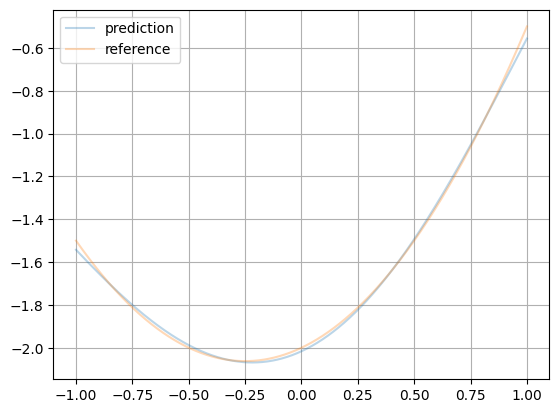

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(x, model(x), c='tab:blue', label='prediction', alpha=0.3)
ax.plot(x, y, c='tab:orange', label='reference', alpha=0.3)
ax.legend()
ax.grid(True)
plt.show()

## Extract weights and biases

To export the neural network from TensorFlow to Modelica we need to extract
weights and biases for each layer and generate corresponding Modelica code.

Remember that TensorFlow uses weight representation

$$ y = f(x W^T + b) $$

to be fast on large data sets, but NeuralNetwork library expects format

$$ y = f(W x + b). $$

In [6]:
weights_and_biases = []
for layer in model.layers:
    layer_weights = layer.get_weights()
    weights_and_biases.append(layer_weights)

Install Python module pythontomodelica locally by running

```bash
pip install -e ./PythonToModelica
```

With `to_modelica` we can convert NumPy N-dimensional arrays to Modelica arrays.

In [7]:
from pythontomodelica import to_modelica

modelica_string = []
for i, layer_weights in enumerate(weights_and_biases):
  weights, bias = layer_weights
  modelica_string.append("parameter " + to_modelica(f"layer_{i+1}_weights", weights.transpose()))
  modelica_string.append("parameter " + to_modelica(f"layer_{i+1}_bias", bias))

print("\n".join(modelica_string))

parameter Real[2,1] layer_1_weights = {{-0.95248}, {-0.943175}};
parameter Real[2] layer_1_bias = {0.872633, -0.949252};
parameter Real[1,2] layer_2_weights = {{-2.25385, 1.40389}};
parameter Real[1] layer_2_bias = {0.60548};


Finally we need to copy these parameters into our new Modelica model
`NeuralNetwork.Examples.Utilities.PolynomNetwork` and set the number of inputs,
outputs and neurons for the network and each layer.
Finally we connect:
  - the input to the input layer 
  - the input layer to the output layer
  - the output layer to the output

```modelica
block PolynomNetwork "Neural Network approximating y = u*u + 0.5*u - 2.0 on interval [-1,1]"
  extends NeuralNetwork.Networks.Interfaces.Network(numInputs = 1, numOutputs = 1);
  Layer.Input inputLayer(
    numInputs = 1,
    numNeurons = 2,
    weights = layer_1_weights,
    bias = layer_1_bias,
    redeclare function f = NeuralNetwork.ActivationFunctions.Tanh
  );
  Layer.Output outputLayer(
    numInputs = 2,
    numNeurons = 1,
    weights = layer_2_weights,
    bias = layer_2_bias
  );

  parameter Real[2,1] layer_1_weights = {{-0.95248}, {-0.943175}};
  parameter Real[2] layer_1_bias = {0.872633, -0.949252};
  parameter Real[1,2] layer_2_weights = {{-2.25385, 1.40389}};
  parameter Real[1] layer_2_bias = {0.60548};
equation
  connect(u, inputLayer.u);
  connect(inputLayer.y, outputLayer.u);
  connect(outputLayer.y, y);
end PolynomNetwork;
```